In [512]:
from utils import go_to_project_root
from scipy.stats import mode
import data
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import KFold, train_test_split
from matplotlib import pyplot as plt

from sklearn.neural_network import MLPClassifier, BernoulliRBM
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
import sklearn.svm
import keras
from sklearn.feature_selection import RFE
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [485]:
def classify(classifier, xtrain, ytrain, xtest, ytest):
    classifier.fit(xtrain, ytrain)
    pred = predict(classifier, xtest)
    return balanced_accuracy_score(ytest, pred)

def feature_elim(classifier, xtrain, ytrain):
    rfe = RFE(estimator=classifier, n_features_to_select=n_features, step=10)
    rfe.fit(xtrain, ytrain)
    return rfe.ranking_

def get_new_xtests(path): 
    path = data_root[:-1] + "s/" + path
    xtest = []
    for file in os.listdir(path + "X_test/"):
        xtest += [pd.read_csv(path + "X_test/" + file, index_col=0).to_numpy()[:, [2, 3, 4, 5]]]
    return xtest

def read_data(_path):
    path = data_root + _path
    xtrain = pd.read_csv(path + "X_train.csv", index_col=0).to_numpy()[:200].astype(float)
    ytrain = pd.read_csv(path + "y_train.csv", index_col=0).to_numpy()[:200]
    ytest = pd.read_csv(path + "y_test.csv", index_col=0).to_numpy()
    xtest = []
    for file in os.listdir(path + "X_test/"):
        xtest += [pd.read_csv(path + "X_test/" + file, index_col=0).to_numpy()]

    new_xt = get_new_xtests(_path)
    mean_xt = [np.mean(new_xt[0], axis=0) for xt in new_xt]

    for i, x in enumerate(xtest):
        xtest[i][:,[2, 3, 4, 5]] = mean_xt[i]

    return xtrain, ytrain, xtest, ytest

def predict(classifier, xtest):
    majority_vote_preds = []
    for x in xtest:
        x = x[:, list(selected[0])]
        majority_vote_preds += [np.sum(classifier.predict(x).astype(int)) > 1]
    return majority_vote_preds

In [472]:
go_to_project_root()
data_root = "data/processed/800/"
datasets = [read_data(f"K{k+1}/") for k in range(3)]

In [513]:
xgboost = []
for k in range(5, 300, 5):
    n_features=50
    mean = 0
    for i in range(3):
        xtrain, ytrain, xtest, ytest = datasets[i]
        c = xgb.XGBClassifier()
        selected = np.where(feature_elim(c, xtrain, ytrain) == 1)
        mean += classify(c, xtrain[:, list(selected[0])], ytrain, xtest, ytest)
    if i % 50 == 0:
        print(f"{i} iterations completed.")
    xgboost += [mean / 3]

TypeError: unsupported operand type(s) for +=: 'module' and 'list'

Text(0, 0.5, 'Testing accuracy')

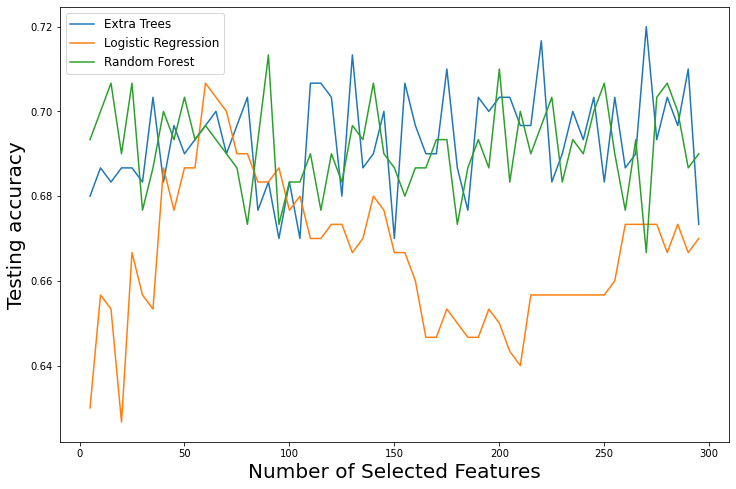

In [506]:
plt.figure(figsize=(12, 8))
plt.plot(range(5, 300, 5), extra, label="Extra Trees")
plt.plot(range(5, 300, 5), logs, label="Logistic Regression")
plt.plot(range(5, 300, 5), randomf, label="Random Forest")

plt.legend(fontsize=12)
plt.xlabel("Number of Selected Features", fontsize=20)
plt.ylabel("Testing accuracy", fontsize=20)